In [1]:
import sys

import numpy as np
import pandas as pd

import time
from datetime import datetime, timedelta

from operator import itemgetter
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 80) 

In [2]:
from IPython.display import clear_output

In [3]:
df_clients = pd.read_csv("./data/df_clients_08_3.csv", sep=',', encoding='utf-8')
df_clients.drop(filter(lambda s: s.startswith("PCL_"), df_clients.columns) + ['Y_pred'],
                inplace=True, axis=1)
df_clients.head()

,FF_POS_amount_2016-10_log,FF_POS_amount_2016-11_log,FF_POS_amount_2016-12_log,FF_POS_amount_2017-01_log,FF_POS_amount_2017-02_log,FF_POS_amount_2017-03_log,FF_POS_amount_2017-04_log,FF_POS_amount_2017-05_log,FF_POS_amount_2017-06_log,FF_POS_amount_2017-07_log,FF_POS_amount_2017-08_log,FF_POS_amount_2017-09_log,FF_POS_amount_2017-10_log,FF_POS_amount_2017-11_log,FF_POS_amount_2017-12_log,FF_POS_amount_2018-01_log,FF_POS_amount_2018-02_log,FF_POS_amount_2018-03_log,FF_POS_amount_2018-04_log,FF_POS_amount_quarter1_log,FF_POS_amount_quarter2_log,FF_POS_amount_quarter3_log,FF_POS_amount_quarter4_log,FF_amount_POS,FF_amount_POS_div_100_log,FF_amount_POS_div_100_mean_log,FF_amount_POS_div_100_std,FF_amount_POS_last_month_log,FF_amount_POS_log,FF_amount_POS_max_log,FF_amount_POS_mean_log,FF_amount_balanced,FF_amount_balanced_mean_window_week,FF_amount_dayoff_log,FF_amount_dayoff_mean_log,FF_amount_holiday_after_7_log,FF_amount_holiday_before_7_log,FF_amount_holiday_log,FF_amount_holiday_mean_log,FF_amount_in_EUR_currency_log,...,FF_mcc_cat_5722_amount_log,FF_mcc_cat_5812_amount_log,FF_mcc_cat_5814_amount_log,FF_mcc_cat_5912_amount_log,FF_mcc_cat_5921_amount_log,FF_mcc_cat_5999_amount_log,FF_mcc_cat_6011_amount_log,FF_mcc_cat_6012_amount_log,FF_mcc_cat_8999_amount_log,FF_mcc_top0_amount_log,FF_mcc_top0_amount_mean_log,FF_mcc_top1_amount_log,FF_mcc_top1_amount_mean_log,FF_mcc_top2_amount_log,FF_mcc_top2_amount_mean_log,FF_num_trans_in_per_day,FF_num_trans_out_per_day,FF_num_trans_per_day,FF_trxday_mean,FF_trxday_std,FF_used_period_days,cl_id,FF_amount_POS_per_month,FF_amount_POS_per_month_log,FF_cu_ratio_days_month,FF_cu_ratio_days_week,FF_cu_ratio_days_days,FF_amount_log_out_in_ratio_per_day,FF_amount_in_log_per_day,FF_amount_out_log_per_day,FF_amount_withdraw_log_per_day,FF_amount_balanced_per_day,channel_type,target_flag,target_sum,FF_channel_type_1,FF_channel_type_2,FF_channel_type_3,FF_channel_type_4,FF_channel_type_5
0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.861492,0.0,6.64379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.964696,0.0,7821.000000,4.356709,3.283414,22.052967,6.643790,8.964696,8.521982,7.866339,-24383.000000,-2260.104167,0.000000,0.000000,8.964696,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.643790,0.000000,9.903538,10.506792,0.000000,8.521982,8.521982,7.616776,7.616776,6.643790,6.643790,0.018182,0.072727,0.090909,386.800000,21.276748,55,0,3910.500000,4.482348,27.500000,27.500000,27.500000,-0.097364,0.180064,-0.194557,0.000000,-443.327273,0,0.0,0.0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.00000,0.000000,8.276715,8.244991,11.878687,10.318540,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8.953997,12.069389,0.0,182185.976007,7.481556,2.921243,60.540964,11.931104,12.112789,11.002117,7.498217,-137185.976007,-1352.140614,0.000000,0.000000,11.851599,10.857969,8.555837,7.457609,11.010297,...,0.000000,10.485589,11.319852,7.800573,0.000000,6.516193,11.884496,0.000000,0.000000,11.319852,7.606765,10.485589,7.541653,9.889628,7.405278,0.021505,1.096774,1.118280,344.298077,23.389849,93,1,45546.494002,3.028197,23.250000,7.153846,1.823529,-0.110848,0.123243,-0.132853,0.116342,-1475.118022,0,0.0,0.0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,10.763,10.782968,11.231806,9.80669,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,12.048980,9.806690,0.000000,0.0,189077.720000,7.503290,2.430098,18.467791,11.436245,12.149919,9.343997,6.986053,-319237.720000,-1882.561297,8.364275,6.978680,11.671427,11.408288,8.600799,6.809959,0.000000,...,0.000000,10.475268,10.256703,7.296617,0.000000,7.003974,11.827013,0.000000,8.967632,10.256703,6.215616,10.475268,6.949839,9.637893,7.073726,0.033333,2.177778,2.211111,164.095477,24.412200,90,2,47269.430000,3.037480,22.500000,6.428571,1.363636,-0.116983,0.094044,-0.140983,0.131165,-3547.085778,0,NaN,NaN,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.00000,10.829107

In [4]:
df_clients["target_sum"] = np.log(1.0 + df_clients["target_sum"])

In [5]:
target = "target_sum"

features = filter(lambda s: s not in {
        "cl_id", "target_flag", "target_sum", "trx_datetime", "channel_type"
    }, df_clients.columns)
features = ["cl_id"] + features
features

['cl_id',
 u'FF_POS_amount_2016-10_log',
 u'FF_POS_amount_2016-11_log',
 u'FF_POS_amount_2016-12_log',
 u'FF_POS_amount_2017-01_log',
 u'FF_POS_amount_2017-02_log',
 u'FF_POS_amount_2017-03_log',
 u'FF_POS_amount_2017-04_log',
 u'FF_POS_amount_2017-05_log',
 u'FF_POS_amount_2017-06_log',
 u'FF_POS_amount_2017-07_log',
 u'FF_POS_amount_2017-08_log',
 u'FF_POS_amount_2017-09_log',
 u'FF_POS_amount_2017-10_log',
 u'FF_POS_amount_2017-11_log',
 u'FF_POS_amount_2017-12_log',
 u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_2018-02_log',
 u'FF_POS_amount_2018-03_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter1_log',
 u'FF_POS_amount_quarter2_log',
 u'FF_POS_amount_quarter3_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_POS',
 u'FF_amount_POS_div_100_log',
 u'FF_amount_POS_div_100_mean_log',
 u'FF_amount_POS_div_100_std',
 u'FF_amount_POS_last_month_log',
 u'FF_amount_POS_log',
 u'FF_amount_POS_max_log',
 u'FF_amount_POS_mean_log',
 u'FF_amount_balanced',
 u'FF_amount_balance

## Ансамбль моделей

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFECV

In [7]:
params_cl = dict()

In [8]:
mask = df_clients[target].notnull()
df_clients_train = df_clients.loc[mask]
df_clients_train.head()

,FF_POS_amount_2016-10_log,FF_POS_amount_2016-11_log,FF_POS_amount_2016-12_log,FF_POS_amount_2017-01_log,FF_POS_amount_2017-02_log,FF_POS_amount_2017-03_log,FF_POS_amount_2017-04_log,FF_POS_amount_2017-05_log,FF_POS_amount_2017-06_log,FF_POS_amount_2017-07_log,FF_POS_amount_2017-08_log,FF_POS_amount_2017-09_log,FF_POS_amount_2017-10_log,FF_POS_amount_2017-11_log,FF_POS_amount_2017-12_log,FF_POS_amount_2018-01_log,FF_POS_amount_2018-02_log,FF_POS_amount_2018-03_log,FF_POS_amount_2018-04_log,FF_POS_amount_quarter1_log,FF_POS_amount_quarter2_log,FF_POS_amount_quarter3_log,FF_POS_amount_quarter4_log,FF_amount_POS,FF_amount_POS_div_100_log,FF_amount_POS_div_100_mean_log,FF_amount_POS_div_100_std,FF_amount_POS_last_month_log,FF_amount_POS_log,FF_amount_POS_max_log,FF_amount_POS_mean_log,FF_amount_balanced,FF_amount_balanced_mean_window_week,FF_amount_dayoff_log,FF_amount_dayoff_mean_log,FF_amount_holiday_after_7_log,FF_amount_holiday_before_7_log,FF_amount_holiday_log,FF_amount_holiday_mean_log,FF_amount_in_EUR_currency_log,...,FF_mcc_cat_5722_amount_log,FF_mcc_cat_5812_amount_log,FF_mcc_cat_5814_amount_log,FF_mcc_cat_5912_amount_log,FF_mcc_cat_5921_amount_log,FF_mcc_cat_5999_amount_log,FF_mcc_cat_6011_amount_log,FF_mcc_cat_6012_amount_log,FF_mcc_cat_8999_amount_log,FF_mcc_top0_amount_log,FF_mcc_top0_amount_mean_log,FF_mcc_top1_amount_log,FF_mcc_top1_amount_mean_log,FF_mcc_top2_amount_log,FF_mcc_top2_amount_mean_log,FF_num_trans_in_per_day,FF_num_trans_out_per_day,FF_num_trans_per_day,FF_trxday_mean,FF_trxday_std,FF_used_period_days,cl_id,FF_amount_POS_per_month,FF_amount_POS_per_month_log,FF_cu_ratio_days_month,FF_cu_ratio_days_week,FF_cu_ratio_days_days,FF_amount_log_out_in_ratio_per_day,FF_amount_in_log_per_day,FF_amount_out_log_per_day,FF_amount_withdraw_log_per_day,FF_amount_balanced_per_day,channel_type,target_flag,target_sum,FF_channel_type_1,FF_channel_type_2,FF_channel_type_3,FF_channel_type_4,FF_channel_type_5
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.861492,0.0,6.64379,0.0,0.0,0.0,0.0,0.000000,0.000000,8.964696,0.0,7821.000000,4.356709,3.283414,22.052967,6.643790,8.964696,8.521982,7.866339,-24383.000000,-2260.104167,0.000000,0.000000,8.964696,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.643790,0.000000,9.903538,10.506792,0.000000,8.521982,8.521982,7.616776,7.616776,6.643790,6.643790,0.018182,0.072727,0.090909,386.800000,21.276748,55,0,3910.500000,4.482348,27.50,27.500000,27.500000,-0.097364,0.180064,-0.194557,0.000000,-443.327273,0,0.0,0.000000,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,8.276715,8.244991,11.878687,10.318540,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,8.953997,12.069389,0.0,182185.976007,7.481556,2.921243,60.540964,11.931104,12.112789,11.002117,7.498217,-137185.976007,-1352.140614,0.000000,0.000000,11.851599,10.857969,8.555837,7.457609,11.010297,...,0.000000,10.485589,11.319852,7.800573,0.000000,6.516193,11.884496,0.000000,0.000000,11.319852,7.606765,10.485589,7.541653,9.889628,7.405278,0.021505,1.096774,1.118280,344.298077,23.389849,93,1,45546.494002,3.028197,23.25,7.153846,1.823529,-0.110848,0.123243,-0.132853,0.116342,-1475.118022,0,0.0,0.000000,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,10.853394,11.676312,10.416270,11.417794,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,12.040357,11.730638,0.000000,0.0,293778.468834,7.965893,3.293833,58.777212,11.442013,12.590585,10.936050,7.881429,-261666.848834,-2153.340938,9.466186,7.857057,12.421177,10.864421,9.466186,7.857057,8.110892,...,8.625330,8.104703,5.513429,7.498316,0.000000,6.268654,12.245298,10.430562,0.000000,10.772384,7.339025,11.289507,8.724708,8.881517,6.803047,0.053763,1.473118,1.526882,209.950704,27.567667,93,5,73444.617208,3.147646,23.25,6.642857,1.550000,-0.115423,0.127715,-0.138852,0.121123,-2813.622030,0,1.0,12.695305,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9.059634,7.699430,7.352441,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.

### Random forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
features_remove = set()

In [11]:
features_ = filter(lambda f: f not in features_remove, features)

scores = []
feature_importances = []

kf = KFold(n_splits=5, shuffle=True, random_state=8888)

for train_index, valid_index in kf.split(df_clients_train):
    cl = RandomForestRegressor(n_estimators=400, criterion='mse', random_state=8888)
    
    X_train = df_clients_train.iloc[train_index].loc[:, features_].values
    Y_train = df_clients_train.iloc[train_index].loc[:, target].values
    
    X_valid = df_clients_train.iloc[valid_index].loc[:, features_].values
    Y_valid = df_clients_train.iloc[valid_index].loc[:, target].values
    
    cl.fit(X_train, Y_train)
    Y_pred = np.clip(cl.predict(X_valid), 0, None)
    
    feature_importances.append(cl.feature_importances_)
    scores.append(np.sqrt(mean_squared_error(Y_valid, Y_pred)))
    print scores[-1]
    
print "=" * 30
print "MEAN:", np.mean(scores)

4.069593480225818
3.925695273303387
3.9318740660272598
4.1409651341385505
MEAN: 4.034338866227802


Feature ranking:
[001] FF_cu_month                              0.258523861468
[002] cl_id                                    0.135240577448
[003] FF_trxday_std                            0.0161334720991
[004] FF_amount_POS_last_month_log             0.013361682217
[005] FF_used_period_days                      0.0131698041265
[006] FF_amount_out_log_per_day                0.0107470986948
[007] FF_amount_log_out_in_ratio_per_day       0.00995935596845
[008] FF_amount_balanced                       0.00861455156446
[009] FF_amount_log_POS_std                    0.00832304488517
[010] FF_log_amount_POS_last_month             0.00785900628262
[011] FF_mcc_top2_amount_mean_log              0.0074213128247
[012] FF_cu_week                               0.0071384544674
[013] FF_mcc_top1_amount_mean_log              0.00661502620147
[014] FF_cu_ratio_days_month                   0.00660366842164
[015] FF_exit_day                              0.00609883715092
[016] FF_log_amount_POS_q0.05     

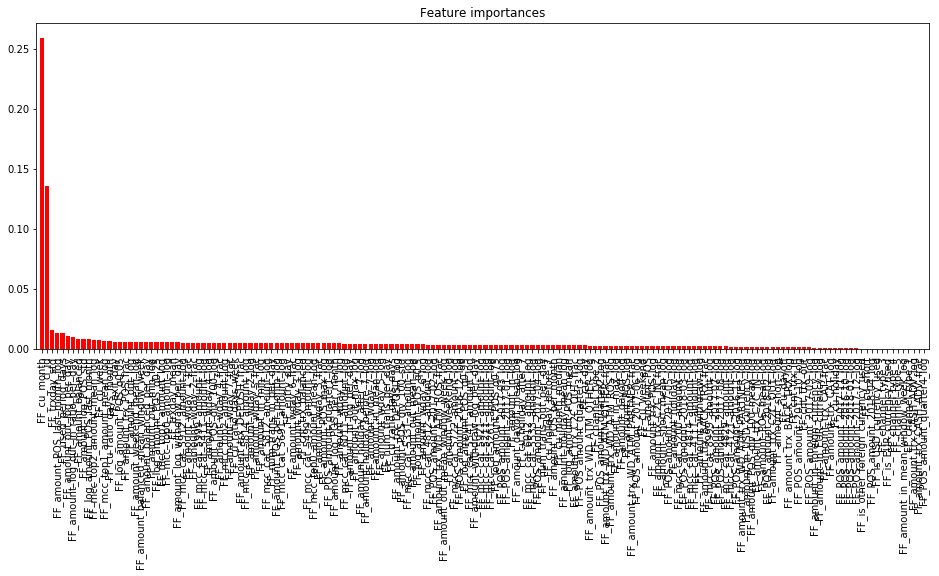

In [12]:
features_ = np.array(features_)

importances = np.mean(feature_importances, axis=0)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]

print "Feature ranking:"

n_features = len(features_)

for f in range(n_features):
    print "[{:03}] {:40} {}".format(f + 1, features_[indices[f]], importances[indices[f]])
    
plt.figure(figsize=(16, 6))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices], color="r", align="center")
plt.xticks(range(n_features), features_[indices], rotation='vertical')
plt.xlim([-1, n_features])
plt.show()

In [13]:
features_remove = set(f for f, f_im in zip(features_, importances) if f_im < 5e-4)
features_remove

{u'FF_POS_amount_2017-12_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_in_mean_window_week_log',
 u'FF_amount_trx_CASH_ADV_frac',
 u'FF_amount_trx_CASH_ADV_log',
 u'FF_channel_type_1',
 u'FF_channel_type_3',
 u'FF_channel_type_4',
 u'FF_channel_type_5',
 u'FF_cu_short',
 u'FF_is_EUR_currency_used',
 u'FF_is_USD_currency_used',
 u'FF_is_other_foreign_currency_used'}

In [14]:
params_cl['random_forest'] = (
    RandomForestRegressor,
    dict(n_estimators=400, criterion='mse', random_state=8888),
    features_remove,
)

### XGBoost

In [15]:
from xgboost import XGBRegressor

In [16]:
features_remove = set()

In [17]:
features_ = filter(lambda f: f not in features_remove, features)

scores = []
feature_importances = []

kf = KFold(n_splits=5, shuffle=True, random_state=8888)

for train_index, valid_index in kf.split(df_clients_train):
    cl = XGBRegressor(n_estimators=300, max_depth=5, random_state=8888)
    
    X_train = df_clients_train.iloc[train_index].loc[:, features_].values
    Y_train = df_clients_train.iloc[train_index].loc[:, target].values
    
    X_valid = df_clients_train.iloc[valid_index].loc[:, features_].values
    Y_valid = df_clients_train.iloc[valid_index].loc[:, target].values
    
    cl.fit(X_train, Y_train)
    Y_pred = np.clip(cl.predict(X_valid), 0, None)
    
    feature_importances.append(cl.feature_importances_)
    scores.append(np.sqrt(mean_squared_error(Y_valid, Y_pred)))
    print scores[-1]
    
print "=" * 30
print "MEAN:", np.mean(scores)

4.017122747136109
4.140567925742123
3.9537873084835864
3.970355579259357
4.128863040236815
MEAN: 4.042139320171598


Feature ranking:
[001] cl_id                                    0.083779245615
[002] FF_amount_log_POS_per_month              0.0170649942011
[003] FF_trxday_std                            0.0159732438624
[004] FF_amount_POS_last_month_log             0.0137490853667
[005] FF_amount_balanced                       0.0129084242508
[006] FF_amount_out_log_per_day                0.0124879935756
[007] FF_amount_POS                            0.0111225368455
[008] FF_amount_wday_4_frac                    0.0110704209656
[009] FF_amount_wday_2_frac                    0.010824601166
[010] FF_amount_log_POS_std                    0.0105220628902
[011] FF_amount_out_mean_log                   0.0103662209585
[012] FF_amount_balanced_mean_window_week      0.0103434855118
[013] FF_amount_out_min_log                    0.0103336479515
[014] FF_amount_holiday_before_7_log           0.0103134531528
[015] FF_amount_out_log                        0.0103096123785
[016] FF_mcc_top2_amount_mean_log       

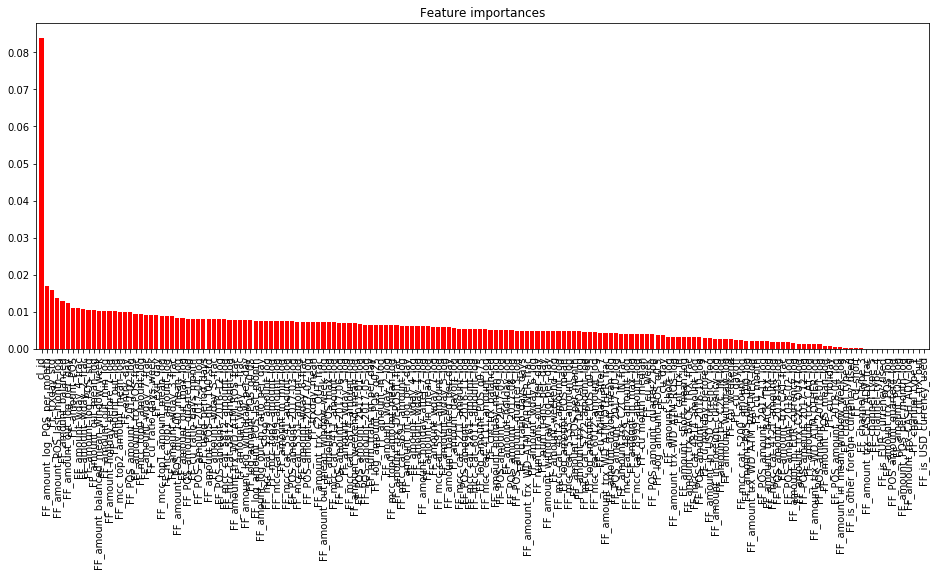

In [18]:
features_ = np.array(features_)

importances = np.mean(feature_importances, axis=0)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]

print "Feature ranking:"

n_features = len(features_)

for f in range(n_features):
    print "[{:03}] {:40} {}".format(f + 1, features_[indices[f]], importances[indices[f]])
    
plt.figure(figsize=(16, 6))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices], color="r", align="center")
plt.xticks(range(n_features), features_[indices], rotation='vertical')
plt.xlim([-1, n_features])
plt.show()

In [19]:
features_remove = set(f for f, f_im in zip(features_, importances) if f_im < 5e-4)
features_remove

{u'FF_POS_amount_quarter4_log',
 u'FF_amount_POS_log',
 u'FF_amount_POS_per_month_log',
 u'FF_amount_in_mean_window_week_log',
 u'FF_amount_trx_CASH_ADV_frac',
 u'FF_amount_trx_CASH_ADV_log',
 u'FF_amount_trx_POS_log',
 u'FF_channel_type_1',
 u'FF_channel_type_2',
 u'FF_channel_type_3',
 u'FF_channel_type_4',
 u'FF_channel_type_5',
 u'FF_cnt_trx_out',
 u'FF_cu_short',
 u'FF_is_EUR_currency_used',
 u'FF_is_USD_currency_used',
 u'FF_is_other_foreign_currency_used'}

In [20]:
features_ = filter(lambda f: f not in features_remove, features)

In [21]:
import xgboost as xgb

In [22]:
%%time

params = {
    'max_depth': 5,
    'learning_rate': 0.001,
    'silent': 0,
    'objective': 'reg:linear',
    'seed': 8888,
}

X_train = xgb.DMatrix(df_clients_train.loc[:, features_], label=df_clients_train.loc[:, target])

trees = 12000
cv = xgb.cv(params, X_train, metrics=('rmse'), show_stdv=True,
            num_boost_round=trees, nfold=5, early_stopping_rounds=150)

CPU times: user 27min 42s, sys: 3.28 s, total: 27min 46s
Wall time: 27min 49s


test-rmse-mean     3.976515
test-rmse-std      0.106930
train-rmse-mean    2.665003
train-rmse-std     0.032197
Name: 6981, dtype: float64


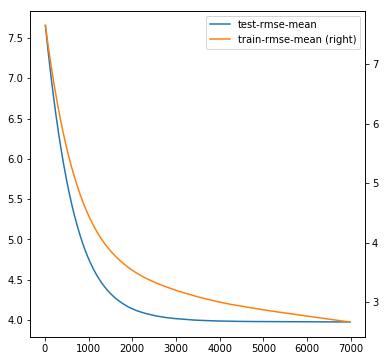

In [23]:
cv[10:].plot(figsize=(6, 6), y=['test-rmse-mean', 'train-rmse-mean'], secondary_y='train-rmse-mean')
print (cv.loc[cv['test-rmse-mean'].values.argmin()])
trees = cv['test-rmse-mean'].values.argmin()

In [24]:
params['n_estimators'] = trees

In [25]:
params_cl['xgb'] = (XGBRegressor, params, features_remove)

### LightGBM

In [26]:
from lightgbm import LGBMRegressor

In [27]:
features_remove = set()

In [28]:
features_ = filter(lambda f: f not in features_remove, features)

scores = []
feature_importances = []

kf = KFold(n_splits=5, shuffle=True, random_state=8888)

for train_index, valid_index in kf.split(df_clients_train):
    cl = LGBMRegressor(n_estimators=400, max_depth=5, learning_rate=0.01, random_state=8888)
    
    X_train = df_clients_train.iloc[train_index].loc[:, features_].values
    Y_train = df_clients_train.iloc[train_index].loc[:, target].values
    
    X_valid = df_clients_train.iloc[valid_index].loc[:, features_].values
    Y_valid = df_clients_train.iloc[valid_index].loc[:, target].values
    
    cl.fit(X_train, Y_train)
    Y_pred = np.clip(cl.predict(X_valid), 0, None)
    
    feature_importances.append(cl.feature_importances_)
    scores.append(np.sqrt(mean_squared_error(Y_valid, Y_pred)))
    print scores[-1]
    
print "=" * 30
print "MEAN:", np.mean(scores)

4.030469270331969
4.032889086404109
3.876483439854538
3.9100756778785377
4.032390624541316
MEAN: 3.9764616198020946


Feature ranking:
[001] cl_id                                    0.0665101211054
[002] FF_trxday_std                            0.0352879786054
[003] FF_used_period_days                      0.0258735024895
[004] FF_amount_log_POS_per_month              0.0252429717566
[005] FF_num_trans_in_per_day                  0.0226121366295
[006] FF_amount_POS_last_month_log             0.0187854673537
[007] FF_amount_balanced                       0.0166981932033
[008] FF_exit_day                              0.0150675102733
[009] FF_log_amount_POS_q0.05                  0.0143717522232
[010] FF_mcc_cat_5999_amount_log               0.0137194790512
[011] FF_amount_trx_DEPOSIT_log                0.013349857587
[012] FF_amount_out_log_per_day                0.0132411453917
[013] FF_mcc_top0_amount_log                   0.0129584936838
[014] FF_cu_month                              0.0126106146588
[015] FF_cu_week                               0.0121540234383
[016] FF_mcc_cat_5812_amount_log       

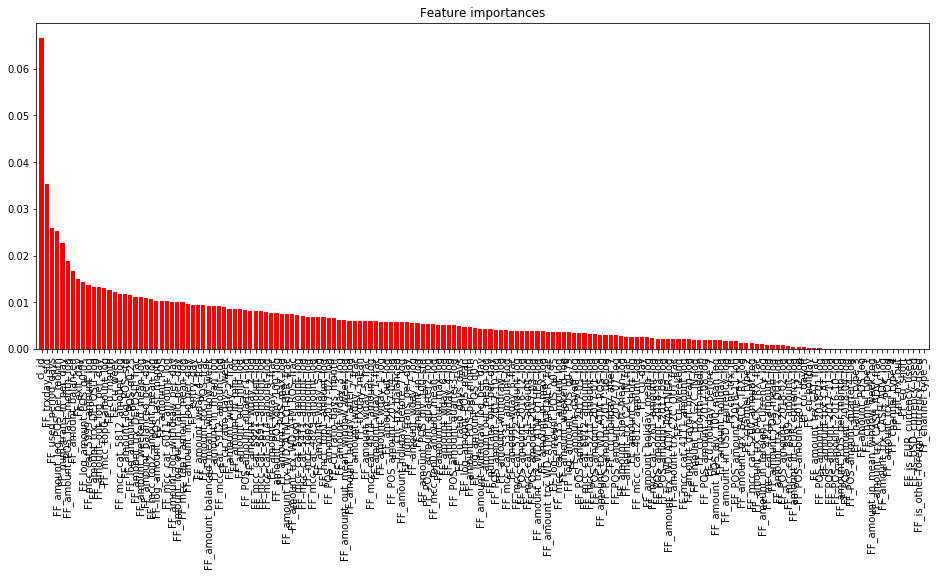

In [29]:
features_ = np.array(features_)

importances = np.mean(feature_importances, axis=0)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]

print "Feature ranking:"

n_features = len(features_)

for f in range(n_features):
    print "[{:03}] {:40} {}".format(f + 1, features_[indices[f]], importances[indices[f]])
    
plt.figure(figsize=(16, 6))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices], color="r", align="center")
plt.xticks(range(n_features), features_[indices], rotation='vertical')
plt.xlim([-1, n_features])
plt.show()

In [30]:
features_remove = set(f for f, f_im in zip(features_, importances) if f_im < 5e-4)
features_remove

{u'FF_POS_amount_2016-10_log',
 u'FF_POS_amount_2017-11_log',
 u'FF_POS_amount_2017-12_log',
 u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_POS_log',
 u'FF_amount_POS_per_month_log',
 u'FF_amount_in_mean_window_week_log',
 u'FF_amount_trx_CASH_ADV_frac',
 u'FF_amount_trx_CASH_ADV_log',
 u'FF_amount_trx_CAT_frac',
 u'FF_amount_trx_CAT_log',
 u'FF_amount_trx_POS_log',
 u'FF_channel_type_1',
 u'FF_channel_type_3',
 u'FF_channel_type_4',
 u'FF_channel_type_5',
 u'FF_cnt_trx_out',
 u'FF_cu_dayoff',
 u'FF_cu_holiday',
 u'FF_cu_short',
 u'FF_is_EUR_currency_used',
 u'FF_is_USD_currency_used',
 u'FF_is_other_foreign_currency_used'}

In [31]:
features_ = filter(lambda f: f not in features_remove, features)

In [32]:
import lightgbm as lgbm

In [33]:
%%time

params = {
    'max_depth': 5,
    'learning_rate': 0.001,
    'silent': 0,
    'objective': 'regression',
    'seed': 8888,
}

X_train = lgbm.Dataset(df_clients_train.loc[:, features_], label=df_clients_train.loc[:, target])

trees = 12000
cv = lgbm.cv(params, X_train, metrics=('rmse'), show_stdv=True, stratified=False,
            num_boost_round=trees, nfold=5, early_stopping_rounds=150)

/usr/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


CPU times: user 8min 14s, sys: 3.29 s, total: 8min 17s
Wall time: 8min 17s


In [34]:
cv = pd.DataFrame(cv)

rmse-mean    3.950725
rmse-stdv    0.096281
Name: 7549, dtype: float64


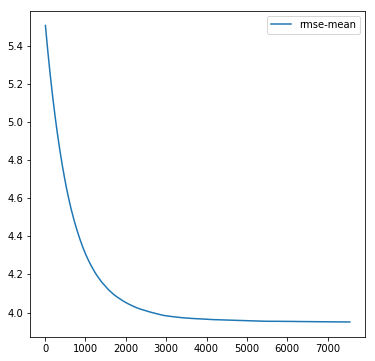

In [35]:
cv[10:].plot(figsize=(6, 6), y=['rmse-mean'])
print (cv.loc[cv['rmse-mean'].values.argmin()])
trees = cv['rmse-mean'].values.argmin()

In [36]:
params['n_estimators'] = trees

In [37]:
params_cl['lgbm'] = (LGBMRegressor, params, features_remove)

### CatBoost

In [38]:
from catboost import CatBoostRegressor

class CatBoostRegressorSklearnWrapper(CatBoostRegressor):
    # Обертка нужна, чтобы работал RFECV
    
    def __getattr__(self, attr):
        if attr == 'coef_':
            return np.array(self.feature_importances_)
        else:
            return object.__getattribute__(self, attr)

In [39]:
features_remove = set()

In [40]:
features_ = filter(lambda f: f not in features_remove, features)

scores = []
feature_importances = []

kf = KFold(n_splits=5, shuffle=True, random_state=8888)

for train_index, valid_index in kf.split(df_clients_train):
    cl = CatBoostRegressor(n_estimators=300, random_state=8888, verbose=False)
    
    X_train = df_clients_train.iloc[train_index].loc[:, features_].values
    Y_train = df_clients_train.iloc[train_index].loc[:, target].values
    
    X_valid = df_clients_train.iloc[valid_index].loc[:, features_].values
    Y_valid = df_clients_train.iloc[valid_index].loc[:, target].values
    
    cl.fit(X_train, Y_train)
    Y_pred = np.clip(cl.predict(X_valid), 0, None)
    
    feature_importances.append(cl.feature_importances_)
    scores.append(np.sqrt(mean_squared_error(Y_valid, Y_pred)))
    print scores[-1]
    
print "=" * 30
print "MEAN:", np.mean(scores)

4.0240254154196995
4.02321493072287
3.8318882940291505
3.8655109338156417
4.090022394144823
MEAN: 3.966932393626437


Feature ranking:
[001] cl_id                                    0.15247331663
[002] FF_cu_month                              0.0954852318633
[003] FF_used_period_days                      0.0692023008117
[004] FF_amount_POS_per_month_log              0.049676586882
[005] FF_amount_log_POS_per_month              0.0490183460198
[006] FF_trxday_std                            0.0282734495075
[007] FF_amount_log_out_in_ratio_per_day       0.0262295931727
[008] FF_cu_week                               0.019869569486
[009] FF_channel_type_2                        0.0191466461691
[010] FF_amount_balanced                       0.015718008252
[011] FF_channel_type_1                        0.0143627224793
[012] FF_amount_balanced_per_day               0.0131781537531
[013] FF_amount_out_log_per_day                0.0122516257771
[014] FF_amount_POS_log                        0.0120738219952
[015] FF_cu_ratio_days_month                   0.0118566994221
[016] FF_amount_POS_last_month_log         

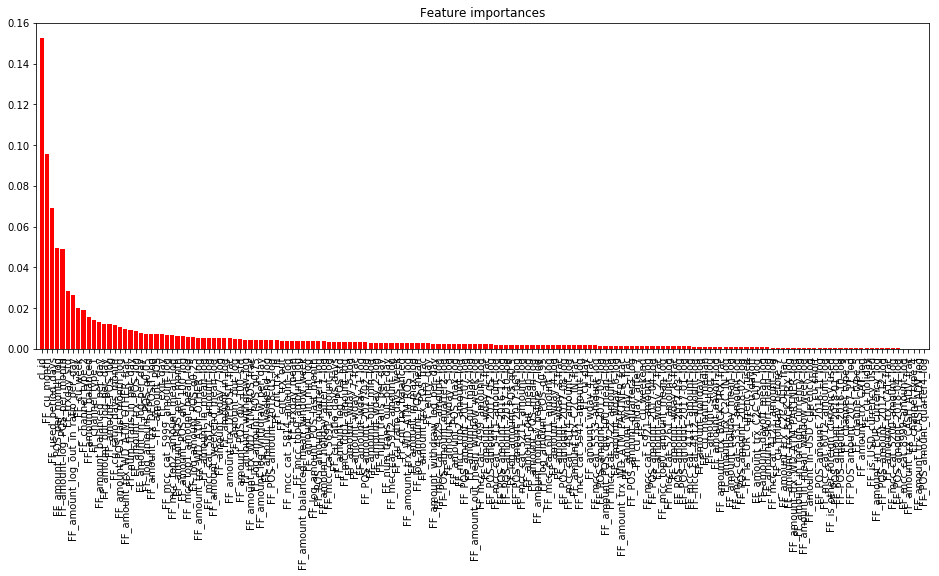

In [41]:
features_ = np.array(features_)

importances = np.mean(feature_importances, axis=0)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]

print "Feature ranking:"

n_features = len(features_)

for f in range(n_features):
    print "[{:03}] {:40} {}".format(f + 1, features_[indices[f]], importances[indices[f]])
    
plt.figure(figsize=(16, 6))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices], color="r", align="center")
plt.xticks(range(n_features), features_[indices], rotation='vertical')
plt.xlim([-1, n_features])
plt.show()

In [42]:
features_remove = set(f for f, f_im in zip(features_, importances) if f_im < 5e-4)
features_remove

{u'FF_POS_amount_2016-10_log',
 u'FF_POS_amount_2017-11_log',
 u'FF_POS_amount_2017-12_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_in_EUR_currency_log',
 u'FF_amount_trx_CASH_ADV_frac',
 u'FF_amount_trx_CASH_ADV_log',
 u'FF_amount_trx_CAT_frac',
 u'FF_amount_trx_CAT_log',
 u'FF_channel_type_3',
 u'FF_channel_type_4',
 u'FF_channel_type_5',
 u'FF_cu_holiday',
 u'FF_is_USD_currency_used',
 u'FF_mcc_cat_5200_amount_log',
 u'FF_mcc_cat_8999_amount_log'}

In [43]:
features_ = filter(lambda f: f not in features_remove, features)

In [44]:
import catboost

In [45]:
%%time

params = {
    'max_depth': 5,
    'learning_rate': 0.001,
    'logging_level': 'Silent',
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'od_wait': 150,
    'random_seed': 8888,
}

X_train = catboost.Pool(df_clients_train.loc[:, features_], label=df_clients_train.loc[:, target])

trees = 7000
cv = catboost.cv(X_train, params, num_boost_round=trees, nfold=5)

CPU times: user 1h 32min 54s, sys: 6min 21s, total: 1h 39min 16s
Wall time: 25min 6s


In [46]:
cv.columns = map(lambda s: s.lower(), cv.columns)

test-rmse-mean     3.976344
test-rmse-std      0.072767
train-rmse-mean    3.702970
train-rmse-std     0.030205
Name: 6999, dtype: float64


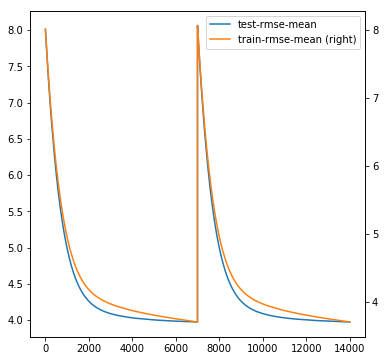

In [47]:
cv[10:].plot(figsize=(6, 6), y=['test-rmse-mean', 'train-rmse-mean'], secondary_y='train-rmse-mean')
print cv.loc[cv['test-rmse-mean'].values.argmin()]
trees = cv['test-rmse-mean'].values.argmin()

In [48]:
trees = 7000

In [49]:
params['n_estimators'] = trees

In [50]:
params_cl['catboost'] = (CatBoostRegressor, params, features_remove)

### Бэггинг из регрессоров

In [59]:
target = "target_sum"

features = filter(lambda s: s not in {
        "cl_id", "target_flag", "target_sum", "trx_datetime", "channel_type"
    }, df_clients.columns)
features = ["cl_id"] + features
features

['cl_id',
 u'FF_POS_amount_2016-10_log',
 u'FF_POS_amount_2016-11_log',
 u'FF_POS_amount_2016-12_log',
 u'FF_POS_amount_2017-01_log',
 u'FF_POS_amount_2017-02_log',
 u'FF_POS_amount_2017-03_log',
 u'FF_POS_amount_2017-04_log',
 u'FF_POS_amount_2017-05_log',
 u'FF_POS_amount_2017-06_log',
 u'FF_POS_amount_2017-07_log',
 u'FF_POS_amount_2017-08_log',
 u'FF_POS_amount_2017-09_log',
 u'FF_POS_amount_2017-10_log',
 u'FF_POS_amount_2017-11_log',
 u'FF_POS_amount_2017-12_log',
 u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_2018-02_log',
 u'FF_POS_amount_2018-03_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter1_log',
 u'FF_POS_amount_quarter2_log',
 u'FF_POS_amount_quarter3_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_POS',
 u'FF_amount_POS_div_100_log',
 u'FF_amount_POS_div_100_mean_log',
 u'FF_amount_POS_div_100_std',
 u'FF_amount_POS_last_month_log',
 u'FF_amount_POS_log',
 u'FF_amount_POS_max_log',
 u'FF_amount_POS_mean_log',
 u'FF_amount_balanced',
 u'FF_amount_balance

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
mask = df_clients[target].notnull()

Y_pred = dict()

for cl_key in params_cl.iterkeys():
    for seed in np.random.randint(100, 10000, 5):
        df_clients_train = df_clients.loc[mask]
        df_clients_test  = df_clients.loc[~mask]
        
        cl_cls, cl_params, features_remove = params_cl[cl_key]
        features_ = filter(lambda f: f not in features_remove, features)
        
        X_train, X_valid, Y_train, Y_valid = train_test_split(
            df_clients_train.loc[:, features_].values,
            df_clients_train.loc[:, target].values,
            test_size=0.2, random_state=seed)
        X_test = df_clients_test.loc[:, features_].values
            
        cl = cl_cls(**cl_params)
        if cl_key == 'catboost':
            cl.set_params(random_seed=seed)
        else:
            cl.set_params(random_state=seed)
        cl.fit(X_train, Y_train)        
        Y_pred['{}_{}'.format(cl_key, seed)] = np.clip(cl.predict(X_test), 0, None)
            
        score = np.sqrt(mean_squared_error(Y_valid, np.clip(cl.predict(X_valid), 0, None)))
        print 'cl={}; seed={:>4d}; score={:>.6f}; done!'.format(cl_key, seed, score)
    print "=" * 80

cl=lgbm; seed=4046; score=4.041618; done!
cl=lgbm; seed=4275; score=3.887105; done!
cl=lgbm; seed=2424; score=3.833476; done!
cl=lgbm; seed=9876; score=3.925500; done!
cl=lgbm; seed=9785; score=3.839235; done!
cl=xgb; seed=9915; score=4.010826; done!
cl=xgb; seed=5780; score=3.832943; done!
cl=xgb; seed=5950; score=3.846186; done!
cl=xgb; seed=2547; score=3.832434; done!
cl=xgb; seed=7123; score=4.049411; done!
cl=catboost; seed=9981; score=3.941741; done!
cl=catboost; seed=2682; score=4.044995; done!
cl=catboost; seed=8602; score=3.938829; done!
cl=catboost; seed=7063; score=3.985675; done!
cl=catboost; seed=5382; score=3.940477; done!
cl=random_forest; seed=5377; score=3.952288; done!
cl=random_forest; seed=6544; score=4.051791; done!
cl=random_forest; seed=8160; score=3.979241; done!
cl=random_forest; seed=7544; score=4.059749; done!
cl=random_forest; seed=4515; score=4.209928; done!


In [62]:
Y_pred = pd.DataFrame(Y_pred, index=df_clients.loc[~mask, "cl_id"])
Y_pred.head()

,catboost_2682,catboost_5382,catboost_7063,catboost_8602,catboost_9981,lgbm_2424,lgbm_4046,lgbm_4275,lgbm_9785,lgbm_9876,random_forest_4515,random_forest_5377,random_forest_6544,random_forest_7544,random_forest_8160,xgb_2547,xgb_5780,xgb_5950,xgb_7123,xgb_9915
cl_id,,,,,,,,,,,,,,,,,,,,
2,10.362401,10.186659,10.072485,10.196096,10.024609,9.682834,10.304829,9.506812,10.640228,9.686521,11.269752,11.075875,10.119727,10.021957,10.191454,10.279328,10.099721,7.773403,9.264152,6.586265
3,5.933677,5.583176,5.474371,5.590344,5.309978,5.153589,5.918757,3.802104,4.762733,5.586424,5.764696,4.350994,4.543018,4.642761,5.226751,3.424957,4.598135,3.852922,4.538913,4.702883
4,10.146889,11.144265,10.326940,10.093070,10.563366,9.925358,10.356634,10.172457,10.188953,9.464326,6.352777,7.181031,9.126420,9.468852,6.162341,11.282272,10.405338,8.782295,11.572626,7.559377
6,11.097404,11.058959,10.670717,10.915489,10.543721,11.280105,11.292568,10.550533,11.735410,10.872733,11.241084,11.441529,9.603116,10.050230,9.899778,11.642631,12.071652,9.644972,11.804914,10.729261
7,10.377187,9.951737,10.186303,10.184925,10.018476,9.505839,9.272518,8.975379,8.715993,10.258896,9.588059,8.762379,7.251899,8.036699,8.919150,8.592877,7.517375,8.376347,9.066873,8.358883


In [63]:
df_pred = pd.DataFrame(Y_pred.mean(axis=1), columns=['pred'])
df_pred['pred'] = np.exp(df_pred['pred']) - 1.0
df_pred.sort_index(inplace=True)
df_pred.head()

,pred
cl_id,
2,19287.326324
3,138.499224
4,13544.090074
6,54574.495782
7,8917.558358


In [64]:
df_pred.to_csv('submission_10_xgb_regr.csv', sep=',', encoding='utf-8', index=True)